<a href="https://colab.research.google.com/github/ComputerFinance/ESWA/blob/main/Portfolio_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Libraries

In [1]:
import os
os.chdir('/content')

In [2]:
!pip install -r 'requirements.txt'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd
import numpy as np
from datetime import datetime
import scipy.cluster.hierarchy as sch
import statsmodels.api as sm
from tqdm import tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import cvxopt as opt
from cvxopt import blas, solvers

%matplotlib inline
plt.close('all')

plt.style.use("seaborn-whitegrid")

import warnings
warnings.filterwarnings('ignore')

solvers.options['show_progress'] = False

## Portfolio Optimization on MV, IVP and HRP

For the optimizations, we are based the implementations present in Prado (2016, 2018).

In [4]:
# On 20151227 by MLdP <lopezdeprado@lbl.gov>
# Hierarchical Risk Parity


def getIVP(cov, **kargs):

    # Compute the inverse-variance portfolio
    ivp = 1. / np.diag(cov)
    ivp /= ivp.sum()
    return ivp

def getClusterVar(cov,cItems):

    # Compute variance per cluster
    cov_=cov.loc[cItems,cItems] # matrix slice
    w_=getIVP(cov_).reshape(-1,1)
    cVar=np.dot(np.dot(w_.T,cov_),w_)[0,0]
    return cVar

def getQuasiDiag(link):

    # Sort clustered items by distance
    link = link.astype(int)
    sortIx = pd.Series([link[-1, 0], link[-1, 1]])
    numItems = link[-1, 3]  # number of original items
    while sortIx.max() >= numItems:
        sortIx.index = range(0, sortIx.shape[0] * 2, 2)  # make space
        df0 = sortIx[sortIx >= numItems]  # find clusters
        i = df0.index
        j = df0.values - numItems
        sortIx[i] = link[j, 0]  # item 1
        df0 = pd.Series(link[j, 1], index=i + 1)
        sortIx = sortIx.append(df0)  # item 2
        sortIx = sortIx.sort_index()  # re-sort
        sortIx.index = range(sortIx.shape[0])  # re-index
    return sortIx.tolist()

def getRecBipart(cov, sortIx):

    # Compute HRP alloc
    w = pd.Series(1, index=sortIx)
    cItems = [sortIx]  # initialize all items in one cluster
    while len(cItems) > 0:
        cItems = [i[j:k] for i in cItems for j, k in ((0, len(i) // 2), (len(i) // 2, len(i))) if len(i) > 1]  # bi-section
        for i in range(0, len(cItems), 2):  # parse in pairs
            cItems0 = cItems[i]  # cluster 1
            cItems1 = cItems[i + 1]  # cluster 2
            cVar0 = getClusterVar(cov, cItems0)
            cVar1 = getClusterVar(cov, cItems1)
            alpha = 1 - cVar0 / (cVar0 + cVar1)
            w[cItems0] *= alpha  # weight 1
            w[cItems1] *= 1 - alpha  # weight 2
    return w

def matrix_from_correlation(cov):
  
    vols = np.sqrt(np.diag(cov))
    corr = np.multiply(cov,np.outer(vols**-1, vols**-1))
    # deal with precision errors
    np.fill_diagonal(corr.values, 1) #solve precision errors
    distances = np.sqrt((1 - corr) / 2) 
    np.fill_diagonal(distances.values, 0) #solve precision errors
    corr = pd.DataFrame(corr)
    return corr

def correlDist(corr):

    # A distance matrix based on correlation, where 0<=d[i,j]<=1
    # This is a proper distance metric
    dist = ((1 - corr)/2.)**.5  # distance matrix
    return dist


def getHRP(cov):

    corr = matrix_from_correlation(cov)
    dist = correlDist(corr)
    link = sch.linkage(dist, 'ward')
    # dn = sch.dendrogram(link, labels=cov.index.values) #plot dendogram
    sortIx = getQuasiDiag(link)
    sortIx = corr.index[sortIx].tolist()
    hrp = getRecBipart(cov, sortIx)
    return hrp.sort_index()

def getMV(cov):

    cov = cov.T.values
    n = len(cov)
    N = 100
    mus = [10 ** (5.0 * t / N - 1.0) for t in range(N)]

    # Convert to cvxopt matrices
    S = opt.matrix(cov)
    pbar = opt.matrix(np.ones(cov.shape[0]))

    # Create constraint matrices
    G = -opt.matrix(np.eye(n))  # negative n x n identity matrix
    h = opt.matrix(0.0, (n, 1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)

    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu * S, -pbar, G, h, A, b)['x'] for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S * x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']

    return list(wt)

In [5]:
def get_all_portfolios(returns):
    
    cov = returns.cov()
    hrp = getHRP(cov)
    ivp = getIVP(cov)
    ivp = pd.Series(ivp, index=cov.index)
    mv = getMV(cov)
    mv = pd.Series(mv, index=cov.index)
    
    portfolios = pd.DataFrame([mv, ivp, hrp], index=['MV', 'IVP', 'HRP']).T.sort_values(by='HRP',ascending=False)
    
    return portfolios,cov

In [10]:
def historical_data():
  
  #Read dataset
  prices = pd.read_excel('prices.xlsx').set_index('Date')

  #Drop NaN
  prices = prices.dropna()

  #Normalize data
  prices = prices/prices.iloc[0]

  #Log returns
  log_returns = (prices.pct_change(axis=0)).apply(np.log1p).iloc[1:,:]

  #DataFrame Stocks
  stocks_returns = log_returns.iloc[:, :-2]

  #DataFrame Benchmarks
  bench_returns = log_returns.iloc[:,-2:]

  return stocks_returns,bench_returns

In [11]:
#Returned variables in functions

stocks_returns = historical_data()[0]
bench_returns = historical_data()[1]

portfolios = get_all_portfolios(stocks_returns)[0]
covar = get_all_portfolios(stocks_returns)[1]

portfolios

,MV,IVP,HRP
PFE,0.447541,0.264978,0.300226
VRSN,0.203992,0.207939,0.171729
NLOK,0.141413,0.113885,0.123792
VRTX,0.029020,0.104703,0.113811
NVR,0.137854,0.119794,0.111503
ANET,0.010964,0.074901,0.069717
BRAP4,0.023049,0.049611,0.056210
NVDA,0.006166,0.064189,0.053011


## Performance Analysis

In [14]:
def portfolios_performances(methods):

  portfolio_order = portfolios.T.reindex(columns= stocks_returns.columns)

  portfolio_methods = pd.DataFrame()

  dict_performance = {'Cumulative Returns': [],
                      'Expected Annual Return':[],
                      'Annual Volatility':[],
                      'Annual Variance':[],
                      'Sharpe Ratio':[],
                      'Max Drawdown':[],
                      'Beta S&P500':[],
                      'Beta Ibovespa':[]}

  for i in methods:

    weights = np.array(portfolio_order.loc[i])
    invest = pd.DataFrame((stocks_returns * weights).sum(axis=1)).rename(columns={0:f'{i}'})

    #Total Return
    total_return = (((1+invest).cumprod())-1)*100
    tr = total_return[i].values.tolist()[-1]
    dict_performance['Cumulative Returns'].append(tr)

    #Expected Annual Return
    expected_return_annual = np.sum(invest.mean()*252)*100
    dict_performance['Expected Annual Return'].append(expected_return_annual)

    #Annual Volatility
    invest_vol = np.sqrt(weights.T.dot(covar*252).dot(weights))*100
    dict_performance['Annual Volatility'].append(invest_vol)

    #Annual Variance
    invest_var = np.sum(weights.T.dot(covar*252).dot(weights))*100
    dict_performance['Annual Variance'].append(invest_var)

    #Sharpe Ratio
    sharpe = (expected_return_annual)/invest_vol
    dict_performance['Sharpe Ratio'].append(sharpe)

    #Max Drawdown
    invest_cum = (1+invest).cumprod()
    up = invest_cum.expanding(min_periods=1).max()
    dd = (invest_cum/up)-1
    drawdown = np.sum(dd.min())*100
    dict_performance['Max Drawdown'].append(drawdown)

    #Beta
    Y = invest.values
    X = bench_returns['Ibovespa'].values
    Z = bench_returns['S&P500'].values

    X = sm.add_constant(X)
    Z = sm.add_constant(Z)

    model1 = sm.OLS(Y,X)
    result1 = model1.fit()
    beta_invest_ibov = result1.params[1]
    beta_invest_ibov = np.sum(beta_invest_ibov)
    dict_performance['Beta Ibovespa'].append(beta_invest_ibov)

    model2 = sm.OLS(Y,Z)
    result2 = model2.fit()
    beta_invest_sp500 = result2.params[1]
    beta_invest_sp500 = np.sum(beta_invest_sp500)
    dict_performance['Beta S&P500'].append(beta_invest_sp500)
   
    portfolio_temp = invest

    if portfolio_methods.empty == True:
      portfolio_methods = portfolio_temp

    else:
      portfolio_methods = pd.merge(portfolio_methods,portfolio_temp,left_index = True, right_index = True)
      portfolio_methods = pd.DataFrame(portfolio_methods)
  
  #Performance DataFrame
  df_performance = pd.DataFrame(data = dict_performance.values(), index = dict_performance.keys(), columns=['MV','IVP','HRP'])

  #DataFrame Cumulative Returns Portfolios and Benchmarks
  portfolios_methods_cum = (1+portfolio_methods).cumprod()
  portfolios_methods_cum.iloc[0] = 1
  portfolios_methods_cum = pd.DataFrame(portfolios_methods_cum)

  bench_cum = (1+bench_returns).cumprod() #Cumulative returns Benchmarks
  portfolios_methods_cum = pd.merge(portfolios_methods_cum,bench_cum,left_index = True, right_index = True)

  ibov = portfolios_methods_cum.loc[portfolios_methods_cum.index[-1], "Ibovespa"]
  ibov = (ibov-1)*100
  sp500 = portfolios_methods_cum.loc[portfolios_methods_cum.index[-1], "S&P500"]
  sp500 = (sp500-1)*100

  print(f"Cummulative Returns of the Ibovespa was " + f"{np.sum(ibov).round(2)}%")
  print(f"Cummulative Returns of the S&P500 was " + f"{np.sum(sp500).round(2)}% \n")

  plot = portfolios_methods_cum.plot(figsize = (20,10));

  return df_performance, portfolios_methods_cum, plot

Cummulative Returns of the Ibovespa was 100.03%
Cummulative Returns of the S&P500 was 114.61% 



,MV,IVP,HRP
Cumulative Returns,164.799758,228.806195,216.923682
Expected Annual Return,18.713934,22.775818,22.085913
Annual Volatility,18.597591,20.065815,19.829036
Annual Variance,3.458704,4.026369,3.931907
Sharpe Ratio,1.006256,1.135056,1.113817
Max Drawdown,-29.855460,-29.589619,-29.128214
Beta S&P500,0.791998,0.912988,0.890753
Beta Ibovespa,0.336899,0.395860,0.389179


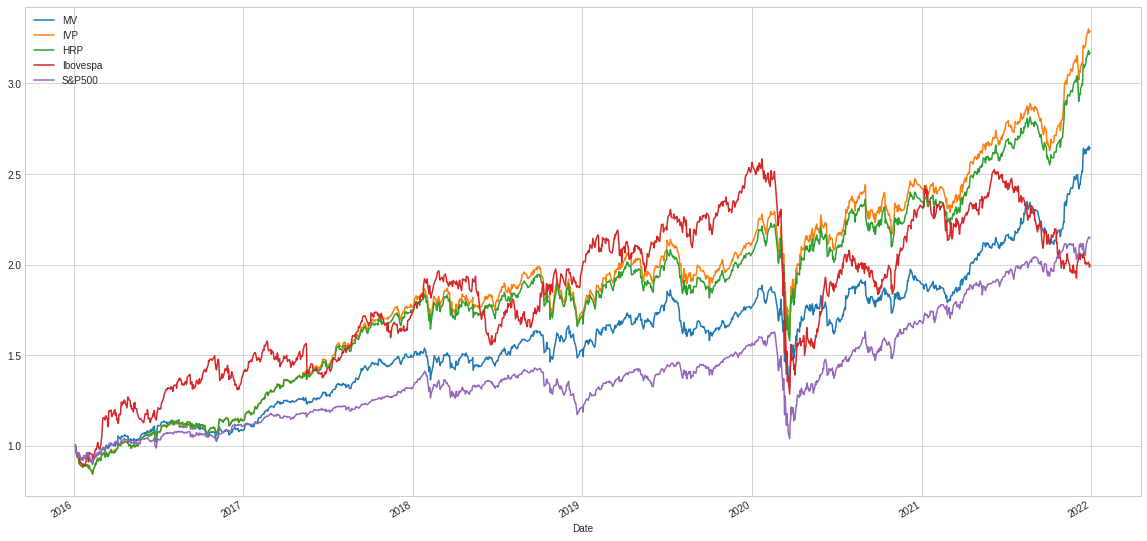

In [15]:
performance, portfolios_cum, plot = portfolios_performances(['MV','IVP','HRP'])
performance

## Monte Carlo Simulations of In-sample and Out-Of-Sample variances distributions

In [16]:
def sample_cov_matrix():

    return covar

def compute_portfolio_variance(weights, cov):

    return np.sum(np.array(weights).T.dot(cov*252).dot(np.array(weights)))

def generate_returns_sample(covariances, horizon):
  
    return pd.DataFrame(np.random.multivariate_normal(np.zeros(len(covariances)), covariances,size=horizon))

In [17]:
methods = {
    'MV': getMV,
    'IVP': getIVP,
    'HRP': getHRP,
}

In [18]:
def monte_carlo_experiment(simulations=10000):

  empirical_variances = {method: {'in-sample' : [], 'out-sample': []} for method in methods.keys()}

  experiments = simulations

  for test in tqdm(range(experiments)):

    true_covariances = sample_cov_matrix()
    in_sample = generate_returns_sample(
        true_covariances, horizon=260)
    out_sample = generate_returns_sample(
        true_covariances, horizon=260)
    
    for name, method in methods.items():

        in_sample_weights = method(in_sample.cov())
        
        in_sample_var = compute_portfolio_variance(
            in_sample_weights, in_sample.cov())
    
        out_sample_var = compute_portfolio_variance(
            in_sample_weights, out_sample.cov())

        empirical_variances[name][
            'in-sample'].append(in_sample_var)
        empirical_variances[name][
            'out-sample'].append(out_sample_var)

  for method, distribs in empirical_variances.items():
    
    plt.hist(distribs['in-sample'], bins=100, label='in-sample', alpha=0.7, color = 'darkgreen')
    plt.hist(distribs['out-sample'], bins=100, label='out-sample', alpha=0.7,color = 'red')
    plt.axvline(x=np.mean(distribs['in-sample']), color='darkgreen',linestyle='dashed', linewidth=3)
    plt.axvline(x=np.mean(distribs['out-sample']), color='red',linestyle='dashed', linewidth=3)
    plt.title(method,fontsize=15)
    plt.legend(loc=1,fontsize=15)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=15)
    plt.grid(True, linewidth=0.3, linestyle='-')
    sns.despine(left=True, bottom=True)
    plt.plot(figsize = (30,24))
    plt.show()
    print('\n')

    print(method + ':\n' +
          'in-sample variance: ' + str(round(np.mean(distribs['in-sample']), 4)) + '\n' +
          'out-sample variance: ' + str(round(np.mean(distribs['out-sample']), 4)) + '\n' +
          '\n\n')

100%|██████████| 10000/10000 [22:31<00:00,  7.40it/s]


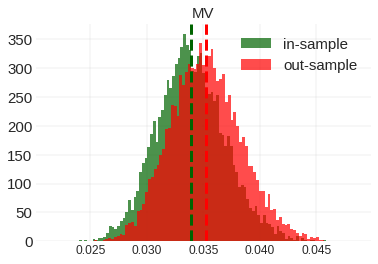



MV:
in-sample variance: 0.0339
out-sample variance: 0.0352





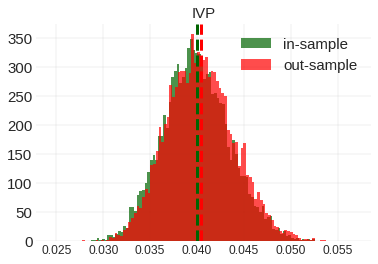



IVP:
in-sample variance: 0.0399
out-sample variance: 0.0404





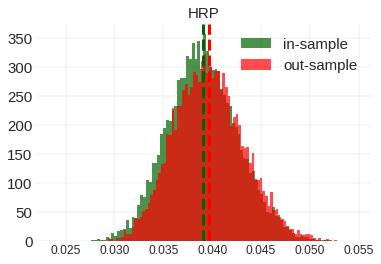



HRP:
in-sample variance: 0.0391
out-sample variance: 0.0397





In [19]:
mmc_in_out = monte_carlo_experiment(simulations=10000)
mmc_in_out